In [13]:
! pip install -q kaggle

In [14]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [05:55<00:00, 21.6MB/s]
100% 6.31G/6.31G [05:55<00:00, 19.1MB/s]


In [16]:
! mkdir train

mkdir: cannot create directory ‘train’: File exists


In [17]:
! unzip /content/histopathologic-cancer-detection.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: 

In [18]:
!pip install pennylane
!pip install qiskit
!pip install pennylane-lightning[gpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import os
import re
import nibabel as nib
import pandas as pd
import numpy as np
import torch
from torch import nn
from fastai.vision import *
from tqdm.notebook import tqdm
# import torchio as tio
# from torchio import AFFINE, DATA
from torchvision import datasets, transforms, models
from torch import optim
from torch.utils.data import DataLoader
from sklearn import preprocessing

import numpy as np
import pandas as pd
import os
import scipy.ndimage as ndi
import shutil

import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)


In [20]:
import time
n_qubits = 5                # Number of qubits
step = 0.000004               # Learning rate
batch_size = 8              # Number of samples for each training step
num_epochs = 25              # Number of training epochs
q_depth = 1                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [21]:
from google.colab import drive
drive.mount('/content/drive',force_remount="True")

Mounted at /content/drive


In [22]:
dev = qml.device("lightning.qubit", wires=n_qubits)

In [23]:
train_path = "/content/train/train"
test_path = "/content/train/test"

train_csv = "/content/train/train_labels.csv"

In [24]:
folders = os.listdir(train_path)
print(len(folders))

220025


In [25]:
train_data = pd.read_csv(train_csv)
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [26]:
print(train_data.query("id == 'afe011cd1711c4b0586a41e0cbe81eaeb8337d4a'")['label'].values[0])

0


In [27]:
train_data_numpy = train_data.values
print(train_data_numpy[0:5])

[['f38a6374c348f90b587e046aac6079959adf3835' 0]
 ['c18f2d887b7ae4f6742ee445113fa1aef383ed77' 1]
 ['755db6279dae599ebb4d39a9123cce439965282d' 0]
 ['bc3f0c64fb968ff4a8bd33af6971ecae77c75e08' 0]
 ['068aba587a4950175d04c680d38943fd488d6a9d' 0]]


In [28]:
from sklearn.model_selection import train_test_split
data_train, data_val= train_test_split(train_data_numpy, test_size = 0.25, random_state=42,stratify=train_data_numpy[:,1])

In [29]:
#testing missing data
import os
f = open("./missing.txt", "w")
root_dir = train_path
for i in tqdm(range(0,int(train_data_numpy.shape[0]))):
  filename = str(train_data_numpy[i][0])
  img_path = root_dir +'/'+ filename + '.tif'
  if(os.path.exists(img_path) == False):
    f.write(str(train_data_numpy[i][0])+"\n")

f.close()


  0%|          | 0/220025 [00:00<?, ?it/s]

In [30]:
files = open("./missing.txt", "r") #opens the file in read mode
missing_img = files.read().splitlines() #puts the file into an array
print(missing_img[0:5])
print(len(missing_img))
files.close()

[]
0


In [31]:
print(len(train_data_numpy))
print(len(data_train))
print(len(data_val))

220025
165018
55007


(96, 96, 3)


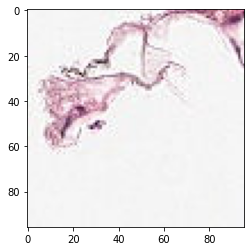

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
img_path = train_path +'/' + '0544c8a53f81a2ec0b293b8caa0d97092fbb0615' + '.tif'
# brain_vol = nib.load(img_path)
# image_array = []
# brain_vol_data = brain_vol.get_fdata()
# fig, axs = plt.subplots(10, 10, figsize=[10, 10])

# for idx, img in enumerate(range(100)):
#     axs.flat[idx].imshow(ndi.rotate(brain_vol_data[img, :, :], 90), cmap='gray')
#     axs.flat[idx].axis('off')
image_array = Image.open(img_path)
numpy_array = np.asarray(image_array)
print(numpy_array.shape)
plt.imshow(image_array)
plt.show()

In [33]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image 
import skimage.transform as skTrans
class CancerClass(Dataset):
  def __init__(self,csv_data,root_dir,transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.data = csv_data

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    filename = str(self.data[idx][0])
    img_path = self.root_dir +'/'+ filename + '.tif'
   
    image_array = Image.open(img_path)
    image_array1 = image_array
    
    del image_array
    
    label = int(self.data[idx][1])
    
    if self.transform:
      tensor_image = self.transform(image_array1)

    return tensor_image,label

In [34]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [47]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [48]:
@qml.qnode(dev, interface="torch",diff_method="adjoint")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # # # Sequence of trainable variational layers
    for k in range(q_depth):
      qml.BasicEntanglerLayers(weights=q_weights, wires=range(n_qubits))
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [49]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.rand(q_depth * n_qubits)) # 2 for QAOA //rand
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [50]:
model_hybrid = models.resnet18(pretrained=True)
model_hybrid.fc = DressedQuantumNet()
model_hybrid = model_hybrid.to(device)

In [51]:
model_hybrid.apply(init_weights)

<ipython-input-34-f9c2b1da9c33>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
batch_size = 16
train_set = CancerClass(data_train,train_path,transforms.Compose(
    [transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

val_set = CancerClass(data_val, train_path, transforms.Compose([transforms.ToTensor()]))
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=False)

In [53]:
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model_hybrid.parameters(),lr=1E-5)
exp_lr_scheduler = lr_scheduler.StepLR(
    opt, step_size=10, gamma=gamma_lr_scheduler
)

In [60]:
def evaluation(dataloader,model):
  with torch.no_grad():
    total,correct = 0,0
    for data in dataloader:
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1) 
     # pred = pred + 1
      total += labels.size(0)
      correct += (pred==labels).sum().item()
    
    return 100*correct/total

In [59]:
loss_arr = []
epoch_loss_arr = []
epoch_acc = []
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    print("Training started:")
    for epoch in range(num_epochs):
      model.train()
      for i, data in enumerate(train_loader,0):
        inputs, labels = data
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
        

      epoch_loss_arr.append(loss.item())
      epoch_acc.append(evaluation(train_loader,model))
      print(model.fc.q_params)
      print(
                "Epoch: {}/{} Train Loss: {:.4f} Train Acc: {:.4f} Val Acc: {:.4f} ".format(
                    epoch,
                    num_epochs,
                    epoch_loss_arr[-1],
                    epoch_acc[-1],
                    evaluation(val_loader,model)
                )
            )
      PATH = '/content/' + 'model_' + str(epoch) + '.pt'
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss.item(),
            }, PATH)
      #best_model_wts = copy.deepcopy(model.state_dict())
      # Update learning rate
      scheduler.step()
      #model.load_state_dict(best_model_wts)
       
    # Print final results
    return model

In [61]:
model_hybrid = train_model(
    model_hybrid, loss_fn, opt, exp_lr_scheduler, num_epochs=25
)

plt.plot(epoch_loss_arr)
plt.show()

Training started:
Parameter containing:
tensor([-2.1444e-07, -3.9359e-18, -5.1506e-20,  4.3697e-10,  1.0480e-02],
       device='cuda:0', requires_grad=True)
Epoch: 0/25 Train Loss: 0.5944 Train Acc: 91.8421 Val Acc: 91.3193 
Parameter containing:
tensor([-1.6059e-05, -2.4114e-06,  2.2362e-16,  9.8136e-09,  1.1521e-07],
       device='cuda:0', requires_grad=True)
Epoch: 1/25 Train Loss: 0.1599 Train Acc: 93.5056 Val Acc: 92.5010 
Parameter containing:
tensor([ 8.4436e-24,  3.8789e-09,  8.0796e-14,  3.5015e-11, -1.6072e-08],
       device='cuda:0', requires_grad=True)
Epoch: 2/25 Train Loss: 0.3871 Train Acc: 94.5842 Val Acc: 93.2863 
Parameter containing:
tensor([ 1.8354e-22,  1.0021e-16, -1.9922e-20,  2.0470e-10,  3.3163e-08],
       device='cuda:0', requires_grad=True)
Epoch: 3/25 Train Loss: 0.2918 Train Acc: 95.4581 Val Acc: 93.6372 
Parameter containing:
tensor([-1.0928e-11,  6.7331e-15, -1.5402e-20, -5.3874e-06, -3.7528e-14],
       device='cuda:0', requires_grad=True)
Epoch: 4/2

KeyboardInterrupt: ignored

In [62]:
PATH = '/content/model_14.pt'
model_hybrid.load_state_dict(torch.load(PATH)['model_state_dict'])
model_hybrid.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#model = model.to(device)

[[97968   213]
 [  306 66531]]


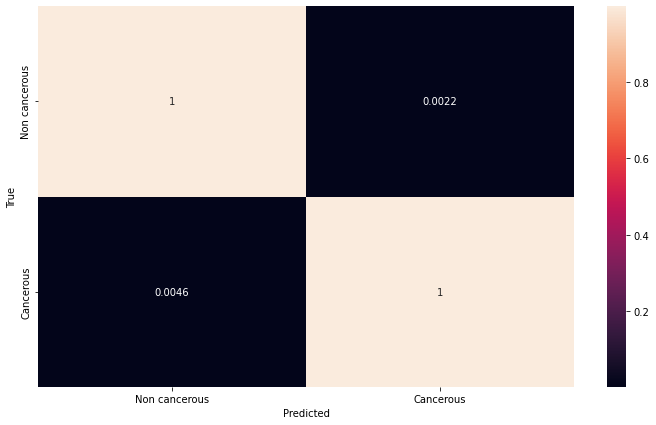

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for i,data in enumerate(train_loader,0):
  inputs,labels = data
  inputs,labels = inputs.to(device),labels.to(device)
  outputs = model_hybrid(inputs)
  
  #_,pred = torch.max(outputs.data,1) 
 
  pred = torch.log_softmax(outputs, dim = 1)
  y_pred_tags = torch.argmax(pred, dim = 1)    ######

  y_pred.extend(y_pred_tags.data.cpu().numpy()) # Save Prediction

  #_,classesmax = torch.max(labels, 1)   #####
  classesmax = labels.data.cpu().numpy()
  y_true.extend(classesmax) # Save Truth

# constant for classes
# 'AD': 3404, 'MCI': 7595, 'CN': 4019
classes = ('Non cancerous','Cancerous')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
#/np.sum(cf_matrix) *10s
df_cm = pd.DataFrame(cf_matrix.astype('float')/cf_matrix.sum(axis=1)[:, np.newaxis], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('output.png')

[[31746   981]
 [ 1493 20787]]


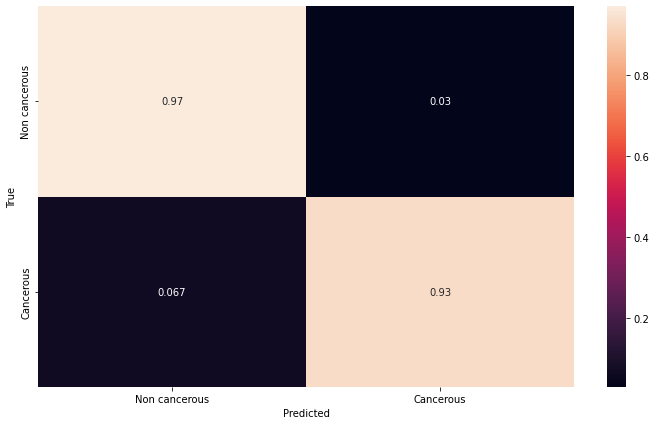

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred_test = []
y_true_test = []

# iterate over test data
for i,data in enumerate(val_loader):
  inputs, labels = data
  inputs,labels = inputs.to(device),labels.to(device)
  outputs = model_hybrid(inputs)
  
  #_,pred = torch.max(outputs.data,1) 
 
  pred = torch.log_softmax(outputs, dim = 1)
  y_pred_tags = torch.argmax(pred, dim = 1)    ######

  y_pred_test.extend(y_pred_tags.data.cpu().numpy()) # Save Prediction

  #_,classesmax = torch.max(labels, 1)   #####
  classesmax = labels.data.cpu().numpy()
  y_true_test.extend(classesmax) # Save Truth

# constant for classes
# 'AD': 3404, 'MCI': 7595, 'CN': 4019
classes = ('Non cancerous','Cancerous')


# Build confusion matrix
cf_matrix = confusion_matrix(y_true_test, y_pred_test)
print(cf_matrix)
#/np.sum(cf_matrix) *10s
df_cm = pd.DataFrame(cf_matrix.astype('float')/cf_matrix.sum(axis=1)[:, np.newaxis], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('output.png')